## Vector Autoregression (VAR)

This script fits an BVAR (Bayesian Vector Autoregression) model to our data to nowcast GDP growth. A vector autoregression is similar to a normal autoregression, but expanded to forecast a set of variables (not just one). We're regressing a vector of our variables at time t as a linear combination of vectors of the same variables at previous periods of our data. 

First, let's load the packages + data we need (essentially copied from ARIMAX GDP growth script).

In [2]:
# PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for BVAR model
import statsmodels

import warnings
warnings.filterwarnings("ignore")

In [5]:
# DATA
data = pd.read_csv("../data/data_wpk.csv")
data = data.drop("gdp", axis = 1)

# make datetime index
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data = data.asfreq("QE")

# filter by date
data_filt = data.loc["2011-03-31" : "2025-06-30"]

In [16]:
from statsmodels.tsa.api import VAR

model = VAR(data_filt)
results = model.fit(1)   # 1 quarter lag (Simple to start, but can tweak this later)

print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Nov, 2025
Time:                     13:49:57
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    123.944
Nobs:                     57.0000    HQIC:                   121.533
Log likelihood:          -4118.82    FPE:                1.37076e+52
AIC:                      120.001    Det(Omega_mle):     2.34758e+51
--------------------------------------------------------------------
Results for equation gdp_yoy
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        43.972865        16.260099            2.704           0.007
L1.gdp_yoy                    0.053981         0.184612            0.292           0.770
L1.orders                 

Nowcast with 1 quarter lag VAR.

In [17]:
forecast = results.forecast(data_filt.values[-4:], steps=1)
nowcast = pd.DataFrame(forecast, columns=data_filt.columns)

print("GDP growth nowcast:", nowcast['gdp_yoy'].iloc[0])

GDP growth nowcast: 2.4593558755303704


Visualize nowcast.

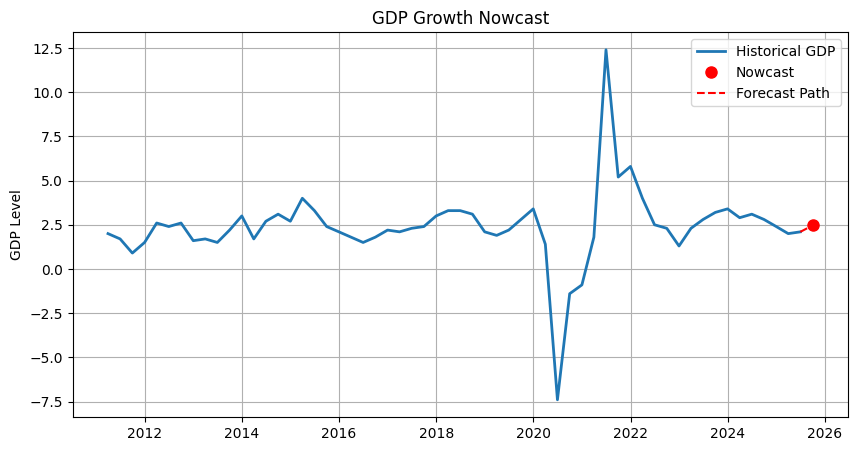

In [ ]:
gdp_hist = data_filt['gdp_yoy'].copy()

fc_series = pd.Series(
    float(nowcast["gdp_yoy"]), 
    index=[gdp_hist.index[-1] + pd.offsets.QuarterEnd()]
)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(gdp_hist, label="Historical GDP", linewidth=2)
plt.plot(fc_series, "ro", label="Nowcast", markersize=8)
plt.plot(pd.concat([gdp_hist.iloc[-1:], fc_series]), "r--", label="Forecast Path")

plt.title("GDP Growth Nowcast")
plt.ylabel("GDP Level")
plt.legend()
plt.grid(True)
plt.show()


Now let's try 4-quarter lag (1 year, pretty standard).

In [ ]:
model_4q = VAR(data_filt)
results_4q = model_4q.fit(4)   # 4 quarter lag (Simple to start, but can tweak this later)

print(results_4q.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Nov, 2025
Time:                     14:02:08
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    121.981
Nobs:                     54.0000    HQIC:                   112.704
Log likelihood:          -3241.98    FPE:                2.88527e+48
AIC:                      106.880    Det(Omega_mle):     1.01599e+46
--------------------------------------------------------------------
Results for equation gdp_yoy
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.699669        27.090745            0.026           0.979
L1.gdp_yoy                   -0.322627         0.249353           -1.294           0.196
L1.orders                 

GDP growth nowcast: 7.158406644948855


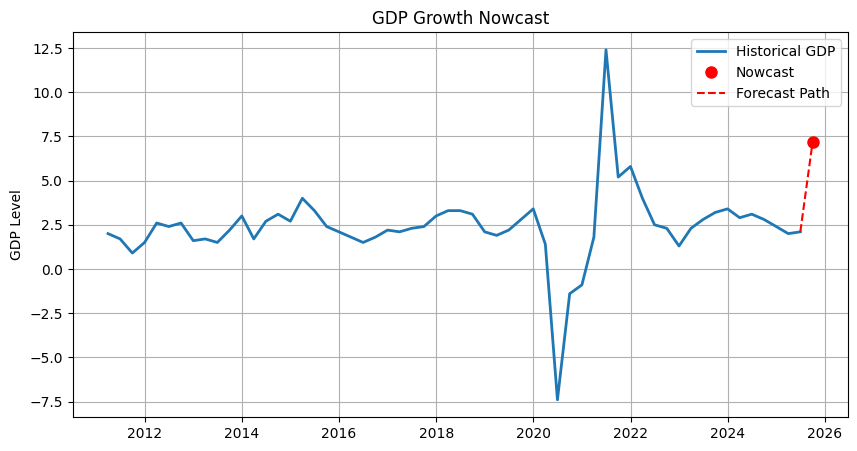

In [25]:
forecast_4q = results_4q.forecast(data_filt.values[-4:], steps=1)
nowcast_4q = pd.DataFrame(forecast_4q, columns=data_filt.columns)

print("GDP growth nowcast:", nowcast_4q['gdp_yoy'].iloc[0])

fc_series_4q = pd.Series(
    float(nowcast_4q["gdp_yoy"]), 
    index=[gdp_hist.index[-1] + pd.offsets.QuarterEnd()]
)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(gdp_hist, label="Historical GDP", linewidth=2)
plt.plot(fc_series_4q, "ro", label="Nowcast", markersize=8)
plt.plot(pd.concat([gdp_hist.iloc[-1:], fc_series_4q]), "r--", label="Forecast Path")

plt.title("GDP Growth Nowcast")
plt.ylabel("GDP Level")
plt.legend()
plt.grid(True)
plt.show()

Dramatic -- this is likely due to not very high frequency data giving unstable results (hopefully a BVAR would be better). 

Let's try a more rigorous way to select the number of lags -- using a information criterion (AIC).

In [31]:
model_auto = VAR(data_filt)
lag_selection = model_auto.select_order(maxlags=4)
print(lag_selection.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       132.8       133.1   4.535e+57       132.9
1       119.7       123.8   1.053e+52       121.3
2       117.6       125.3   1.763e+51       120.5
3       115.2       126.6   5.376e+50       119.6
4      106.9*      122.0*  2.885e+48*      112.7*
-------------------------------------------------


Looks like 4 is the best all around. We need a BVAR to shrink the parameters (or we need to lower the number of predictors). 

I'll try out a BVAR in an R script (Python's BVAR packages are really out of date.)